In [1]:
from dotenv import load_dotenv
from ast import literal_eval

In [2]:
assert load_dotenv()

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

/tmp/ipykernel_2690831/2518516040.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tools = [TavilySearchResults(max_results=3)]


In [4]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4.1-nano")
prompt = "You are a helpful assistant."
agent_executor = create_react_agent(llm, tools, prompt=prompt)

In [5]:
messages = agent_executor.invoke({"messages": [("user", "who is the winnner of the us open")]})['messages']

In [6]:
for msg in messages:
    print(msg.type, )
messages[-1].content

human
ai
tool
ai


"The winner of the most recent US Open in men's singles is Jannik Sinner from Italy, and in women's singles, Aryna Sabalenka."

In [7]:
print(literal_eval(messages[2].content)[0]['content'])

In the doubles events, Sam Stosur and Shuai Zhang won the women's title, while Rajeev Ram and Joe Salisbury claimed the men's crown. Salisbury also teamed with Desirae Krawczyk and to win the mixed. [...] In 2016, the US Open once again earned its reputation as the toughest two weeks in tennis. From its concrete surface to the weather that alternates between summer and fall, a Flushing fortnight is not for the faint of heart. So it seemed only fitting that two of the game’s most tenacious competitors, Angelique Kerber and Stan Wawrinka, emerged as its champions. [...] championship. Also with the victories, Williams and Nadal each took home a record payday of $3.6 million as the US Open and Emirates Airline US Open Series champions. The US Open year of the veteran extended to doubles as well, where 40-year-old Leander Paes won the men’s doubles title with 34-year-old Radek Stepanek, and 36-year-old Max Mirnyi teamed with relative youngster Andrea Hlavackova, 27, to claim the mixed champ

### State

In [8]:
import operator
from typing import Annotated, List, Tuple
from typing_extensions import TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

### planner

In [9]:
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [10]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4.1", temperature=0
).with_structured_output(Plan)


In [11]:
planner.invoke(
    {
        "messages": [
            ("user", "what is the hometown of the current Australia open winner?")
        ]
    }
)

Plan(steps=['Identify the current Australian Open winner (the most recent winner of the tournament).', 'Find the full name of the winner.', 'Look up the hometown or place of birth of the winner.', 'The result from the previous step is the answer.'])

### Re-Plan Step

- 注意 re-plan 的 context

In [12]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o", temperature=0
).with_structured_output(Act)

### Graph

In [13]:
from typing import Literal
from langgraph.graph import END


async def execute_step(state: PlanExecute):
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [(task, agent_response["messages"][-1].content)],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        # 替换新的 plan
        return {"plan": output.action.steps}


def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return END
    else:
        return "agent"

In [14]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
    ["agent", END],
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

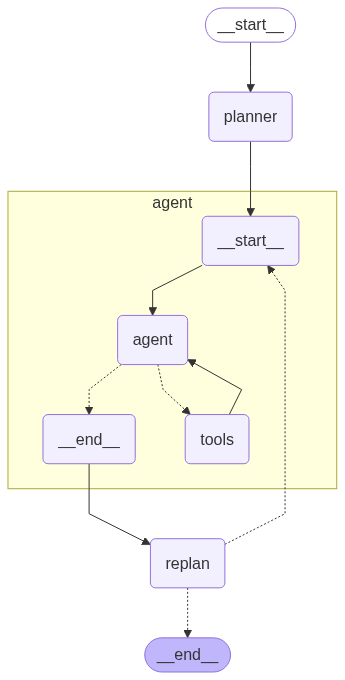

In [15]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [16]:
config = {"recursion_limit": 50}
inputs = {"input": "what is the hometown of the mens 2024 Australia open winner?"}
async for event in app.astream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print(v)

{'plan': ["Identify the winner of the men's 2024 Australian Open.", 'Find the hometown of the identified winner.', 'The result from step 2 is the final answer.']}
{'past_steps': [("Identify the winner of the men's 2024 Australian Open.", "The winner of the men's 2024 Australian Open is Jannik Sinner.")]}
{'plan': ["Find the hometown of Jannik Sinner, the winner of the men's 2024 Australian Open.", 'The result from step 1 is the final answer.']}
{'past_steps': [("Find the hometown of Jannik Sinner, the winner of the men's 2024 Australian Open.", 'The hometown of Jannik Sinner is Sexten, which is in the region of South Tyrol in Northern Italy.')]}
{'response': "The objective has been successfully completed. The hometown of Jannik Sinner, the winner of the men's 2024 Australian Open, is Sexten, located in the region of South Tyrol in Northern Italy. No further steps are needed."}
